In [5]:
import pandas as pd
import numpy as np
import keras
from matplotlib import pyplot as plt

np.random.seed(2)

In [154]:
# Importing the dataset
train_df = pd.read_csv('../Data/train.csv')
test_df = pd.read_csv('../Data/test.csv')

In [155]:
X_train = train_df.iloc[:, :-1]
y_train = pd.DataFrame(train_df.iloc[:, -1])
X_test = test_df.iloc[:, :-1]
y_test = pd.DataFrame(test_df.iloc[:, -1])

In [4]:
X_train.shape

(286940, 98)

In [5]:
X_test.shape

(95647, 98)

## Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
random_forest = RandomForestClassifier(n_estimators=100)

In [8]:
# Pandas Series.ravel() function returns the flattened underlying data as an ndarray.
random_forest.fit(X_train,y_train.values.ravel())    # np.ravel() Return a contiguous flattened array

RandomForestClassifier()

In [9]:
train_RF = random_forest.predict(X_train)
test_RF = random_forest.predict(X_test)

In [10]:
y_pred = random_forest.predict(X_test)

In [11]:
random_forest.score(X_test,y_test)

0.9858646899536838

In [12]:
# Approach to plot confusion matrix (from scikit-learn.org site)
import matplotlib.pyplot as plt
import itertools

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[83867   173]
 [ 1179 10428]]


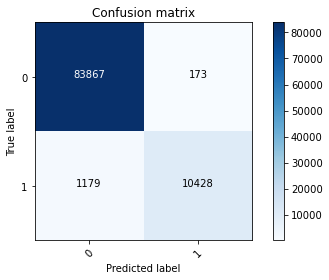

In [13]:
# Confusion matrix on the test dataset
cnf_matrix = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cnf_matrix,classes=[0,1])

- while only 6 regular transactions are wrongly predicted as fraudulent, the model only detects 78% of the fraudulent transactions. As a consequence 33 fraudulent transactions are not detected (False Negatives).
- Let's see if we can improve this performance with other machine learning / deep learning models in the rest of the notebook.

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_roc_curve
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('accuracy:%0.4f'%acc,'\tprecision:%0.4f'%prec,'\trecall:%0.4f'%rec,'\tF1-score:%0.4f'%f1)

accuracy:0.9859 	precision:0.9837 	recall:0.8984 	F1-score:0.9391


Let's store each model's performance in a dataframe for comparison purpose

In [15]:
### Store results in dataframe for comparing various Models
results_testset = pd.DataFrame([['RandomForest', acc, 1-rec, rec, prec, f1]],
               columns = ['Model', 'Accuracy', 'FalseNegRate', 'Recall', 'Precision', 'F1 Score'])
results_testset

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,RandomForest,0.985865,0.101577,0.898423,0.983681,0.939121


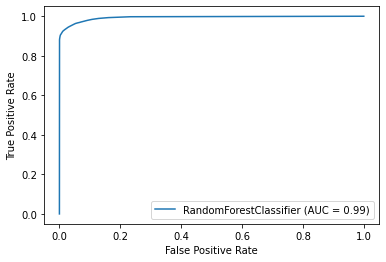

In [16]:
ROC_RF = plot_roc_curve(random_forest, X_test, y_test)
plt.show()

## Decision trees

In [17]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()

In [18]:
decision_tree.fit(X_train,y_train.values.ravel())

DecisionTreeClassifier()

In [19]:
y_pred = decision_tree.predict(X_test)

In [20]:
train_DT = decision_tree.predict(X_train)
test_DT = decision_tree.predict(X_test)

In [21]:
decision_tree.score(X_test,y_test)

0.9798948215835311

Confusion matrix, without normalization
[[83029  1011]
 [  912 10695]]


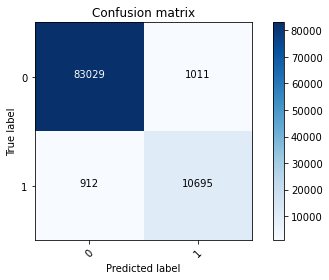

In [22]:
# Confusion matrix on the test dataset
cnf_matrix = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cnf_matrix,classes=[0,1])

- The performance of the Decision Tree model is below the one using Random Forest. Let's check the performance indicators.

In [23]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [24]:
### Store results in dataframe for comparing various Models
model_results = pd.DataFrame([['DecisionTree', acc, 1-rec, rec, prec, f1]],
               columns = ['Model', 'Accuracy', 'FalseNegRate', 'Recall', 'Precision', 'F1 Score'])
results_testset = results_testset.append(model_results, ignore_index = True)
results_testset

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,RandomForest,0.985865,0.101577,0.898423,0.983681,0.939121
1,DecisionTree,0.979895,0.078573,0.921427,0.913634,0.917514


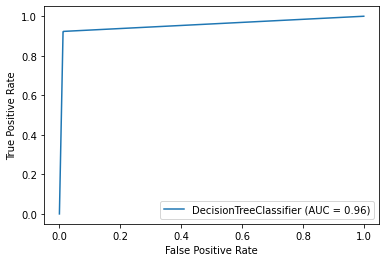

In [25]:
ROC_DT = plot_roc_curve(decision_tree, X_test, y_test)
plt.show()

## Let's now explore Neural Network models

In [162]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_train_baseline = y_train
y_test = np.array(y_test)
# y_test_baseline = y_train

## Deep neural network
- We will use a simple NN made of 5 fully-connected layers with ReLu activation. The NN takes a vector of length 29 as input. This represents the information related to each transactions, ie each line with 98 columns from the dataset. For each transaction, the final layer will output a probability distribution (sigmoid activation function) and classify either as not fraudulent (0) or fraudulent (1).
- a dropout step is included to prevent overfitting.

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [28]:
X_train.shape

(286940, 98)

In [2]:
model = Sequential([
    Dense(units=49, input_dim = 98,activation='relu'),   # input of 98 columns as shown above
    Dense(units=80,activation='relu'),
    Dropout(0.5),
    Dense(80,activation='relu'),
    Dense(49,activation='relu'),
    Dense(1,activation='sigmoid'),                        # binary classification fraudulent or not
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 49)                4851      
_________________________________________________________________
dense_2 (Dense)              (None, 80)                4000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_4 (Dense)              (None, 49)                3969      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 50        
Total params: 19,350
Trainable params: 19,350
Non-trainable params: 0
__________________________________________________

In [4]:
with open('modelsummary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

## Training

In [31]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=200,epochs=20)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/20
286940/286940 [==============================] - 7s 24us/step - loss: 0.0806 - accuracy: 0.9743
Epoch 2/20
286940/286940 [==============================] - 6s 21us/step - loss: 0.0589 - accuracy: 0.9807
Epoch 3/20
286940/286940 [==============================] - 6s 22us/step - loss: 0.0555 - accuracy: 0.9820
Epoch 4/20
286940/286940 [==============================] - 6s 21us/step - loss: 0.0538 - accuracy: 0.9825
Epoch 5/20
286940/286940 [==============================] - 6s 22us/step - loss: 0.0527 - accuracy: 0.9828
Epoch 6/20
286940/286940 [==============================] - 6s 22us/step - loss: 0.0516 - accuracy: 0.9830
Epoch 7/20
286940/286940 [==============================] - 6s 22us/step - loss: 0.0504 - accuracy: 0.9833
Epoch 8/20
286940/286940 [==============================] - 6s 21us/step - loss: 0.0499 - accuracy: 0.9834
Epoch 9/20
286940/286940 [=======================

In [32]:
train_predictions_baseline = model.predict(X_train)
test_predictions_baseline = model.predict(X_test)

In [33]:
score = model.evaluate(X_test, y_test)

95647/95647 [==============================] - 2s 26us/step


In [34]:
print(score)

[0.04659001041607836, 0.9845055341720581]


- The model achieves an accuracy of 99.94% ! Is this a good performance ?
- Remember that our dataset is significantly composed of non fraudulent samples with only 172 fraudulent transactions per 100,000. Consequently, a model predicting every transaction as 'non fraudulent' would achieve 99.83% accuracy despite being unable to detect a single fraudulent case !

Test Data Accuracy: 0.9845


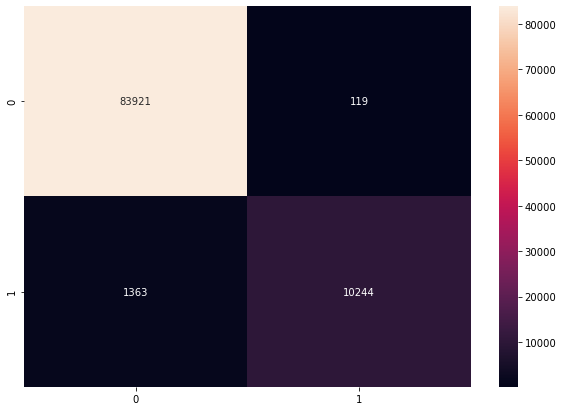

In [35]:
## Confusion Matrix on unsee test set
import seaborn as sn
y_pred = model.predict(X_test)
for i in range(len(y_test)):
    if y_pred[i]>0.5:
        y_pred[i]=1 
    else:
        y_pred[i]=0
cm = confusion_matrix(y_test, y_pred) # rows = truth, cols = prediction
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
#sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

Detection of fraudulent transactions did not improve compared to the previous machine learning models.
- 115 fraudulent transactions are detected as fraudulent by the model, yet 32 fraudulent transactions are not identified (false negative) which remains an issue. Our objective must be to detect as many fraudulent transactions as possible since these can have a huge negative impact.
- 21 regular transactions are detected as potentially fraudulent by the model. These are false positive. This number is negligible.

Conclusion : We must find ways to further reduce the number of false negative.

In [36]:
# Alternative approach to plot confusion matrix (from scikit-learn.org site)
y_pred = model.predict(X_test)
y_test = pd.DataFrame(y_test)    # Pandas format required by confusion_matrix function

In [37]:
cnf_matrix = confusion_matrix(y_test, y_pred.round())   # y_pred.round() to convert probability to either 0 or 1 in line with y_test

In [38]:
print(cnf_matrix)

[[83921   119]
 [ 1363 10244]]


Confusion matrix, without normalization
[[83921   119]
 [ 1363 10244]]


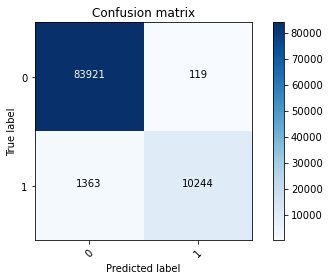

In [39]:
plot_confusion_matrix(cnf_matrix, classes=[0,1])
plt.show()

In [40]:
acc = accuracy_score(y_test, y_pred.round())
prec = precision_score(y_test, y_pred.round())
rec = recall_score(y_test, y_pred.round())
f1 = f1_score(y_test, y_pred.round())

In [41]:
### Store results in dataframe for comparing various Models
model_results = pd.DataFrame([['PlainNeuralNetwork', acc, 1-rec, rec, prec, f1]],
               columns = ['Model', 'Accuracy', 'FalseNegRate', 'Recall', 'Precision', 'F1 Score'])
results_testset = results_testset.append(model_results, ignore_index = True)
results_testset

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,RandomForest,0.985865,0.101577,0.898423,0.983681,0.939121
1,DecisionTree,0.979895,0.078573,0.921427,0.913634,0.917514
2,PlainNeuralNetwork,0.984506,0.117429,0.882571,0.988517,0.932544


### Weighted loss to account for large class imbalance in train dataset
- we will adjust the class imbalance by giving additional weight to the loss associated to errors made on fraudulent transaction detection. Let's review the process:

In [42]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), np.array([y_train[i][0] for i in range(len(y_train))]))
class_weights = dict(enumerate(class_weights))
class_weights

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.5689934839597537, 1: 4.123530595234674}

- The class 'Fraudulent' (y=1) is assigned a weight of 289 vs 0.5 for the class 'not fraudulent' due to the very low prevalence we detected during data exploration. This allows the model to give more importance to the errors made on fraudulent cases during training.

In [43]:
model.fit(X_train,y_train,batch_size=200,epochs=20, class_weight=class_weights, shuffle=True)

Epoch 1/20
286940/286940 [==============================] - 6s 22us/step - loss: 0.0899 - accuracy: 0.9627
Epoch 2/20
286940/286940 [==============================] - 6s 22us/step - loss: 0.0868 - accuracy: 0.9595
Epoch 3/20
286940/286940 [==============================] - 6s 22us/step - loss: 0.0867 - accuracy: 0.9607
Epoch 4/20
286940/286940 [==============================] - 6s 22us/step - loss: 0.0858 - accuracy: 0.9593
Epoch 5/20
286940/286940 [==============================] - 6s 22us/step - loss: 0.0854 - accuracy: 0.9603
Epoch 6/20
286940/286940 [==============================] - 6s 22us/step - loss: 0.0854 - accuracy: 0.9609
Epoch 7/20
286940/286940 [==============================] - 6s 22us/step - loss: 0.0849 - accuracy: 0.9613
Epoch 8/20
286940/286940 [==============================] - 6s 22us/step - loss: 0.0845 - accuracy: 0.9602
Epoch 9/20
286940/286940 [==============================] - 6s 22us/step - loss: 0.0850 - accuracy: 0.9602
Epoch 10/20
286940/286940 [==========

In [188]:
train_predictions_weighted = model.predict(X_train)
test_predictions_weighted = model.predict(X_test)

In [45]:
score_weighted = model.evaluate(X_test, y_test)

95647/95647 [==============================] - 2s 22us/step


In [46]:
print(score_weighted)

[0.0817875347964686, 0.9616820216178894]


Test Data Accuracy: 0.9617


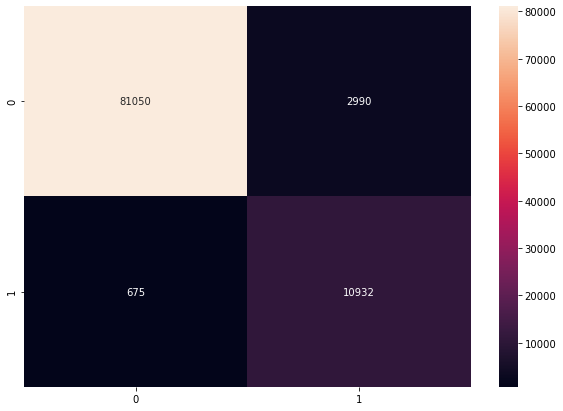

In [47]:
## Confusion Matrix on unseen test set
y_pred = model.predict(X_test)
for i in range(len(y_test)):
    if y_pred[i]>0.5:
        y_pred[i]=1 
    else:
        y_pred[i]=0
cm = confusion_matrix(y_test, y_pred) # rows = truth, cols = prediction
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
#sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

- The accuracy reduced a bit. We need to look at more detailed evaluation measures like precision and recall to gauge the true model performance.
- The model is actually much better at detecting fraudulent cases now. We have a lower False negative rate which is the key criteria for our purpose (detect a fraud when there is one).
- But on the other hand, the model generates an excessive number of false positive compared to the previous approaches. 

In [48]:
acc = accuracy_score(y_test, y_pred.round())
prec = precision_score(y_test, y_pred.round())
rec = recall_score(y_test, y_pred.round())
f1 = f1_score(y_test, y_pred.round())

In [49]:
### Store results in dataframe for comparing various Models
model_results = pd.DataFrame([['WeightedNeuralNetwork', acc, 1-rec, rec, prec, f1]],
               columns = ['Model', 'Accuracy', 'FalseNegRate', 'Recall', 'Precision', 'F1 Score'])
results_testset = results_testset.append(model_results, ignore_index = True)
results_testset

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,RandomForest,0.985865,0.101577,0.898423,0.983681,0.939121
1,DecisionTree,0.979895,0.078573,0.921427,0.913634,0.917514
2,PlainNeuralNetwork,0.984506,0.117429,0.882571,0.988517,0.932544
3,WeightedNeuralNetwork,0.961682,0.058155,0.941845,0.785232,0.856438


- Although the recall metric improves, the F1-score collapses due to extremely poor precision. Given the very high number of transactions processed, the excessive number of false positives is clearly an issue.

## Undersampling
- In order to balance the train set, another technique is undersampling. With this technique, we adjust the largest class to match the number of samples of the under-represented class. Here we want to randomly pick an amount of non-fraudulent transactions equal to the number of fraudulent transactions in the dataset.

In [133]:
data = pd.read_csv('../Data/df_final_preprocessed.csv')

In [134]:
data.shape

(382587, 99)

In [135]:
fraud_indices = np.array(data[data['FraudFound'] == 1].index)
number_records_fraud = len(fraud_indices)
print(number_records_fraud)

46400


In [136]:
normal_indices = data[data['FraudFound'] == 0].index

In [137]:
len(normal_indices)

336187

In [138]:
# Random select N indices from non fraudulent samples (N equals to number of fraudulent records)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace=False)
random_normal_indices = np.array(random_normal_indices)
print(len(random_normal_indices))

46400


In [139]:
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])
print(len(under_sample_indices))

92800


In [140]:
under_sample_data = data.iloc[under_sample_indices,:]

In [141]:
X_undersample = under_sample_data.iloc[:,under_sample_data.columns != 'FraudFound']
y_undersample = under_sample_data.iloc[:,under_sample_data.columns == 'FraudFound']

In [142]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_undersample,y_undersample, test_size=0.3)

In [143]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_train_undersampled = y_train
y_test = np.array(y_test)
y_test_undersampled = y_test

In [144]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 49)                4851      
_________________________________________________________________
dense_17 (Dense)             (None, 80)                4000      
_________________________________________________________________
dropout_4 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 80)                6480      
_________________________________________________________________
dense_19 (Dense)             (None, 49)                3969      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 50        
Total params: 19,350
Trainable params: 19,350
Non-trainable params: 0
__________________________________________________

In [145]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=200,epochs=20)

Epoch 1/20
64960/64960 [==============================] - 3s 44us/step - loss: 0.0892 - accuracy: 0.9509
Epoch 2/20
64960/64960 [==============================] - 2s 33us/step - loss: 0.0856 - accuracy: 0.9525
Epoch 3/20
64960/64960 [==============================] - 2s 32us/step - loss: 0.0841 - accuracy: 0.9542
Epoch 4/20
64960/64960 [==============================] - 2s 32us/step - loss: 0.0839 - accuracy: 0.9538
Epoch 5/20
64960/64960 [==============================] - 2s 30us/step - loss: 0.0836 - accuracy: 0.9541
Epoch 6/20
64960/64960 [==============================] - 2s 24us/step - loss: 0.0826 - accuracy: 0.9545
Epoch 7/20
64960/64960 [==============================] - 2s 24us/step - loss: 0.0825 - accuracy: 0.9551
Epoch 8/20
64960/64960 [==============================] - 2s 24us/step - loss: 0.0824 - accuracy: 0.9554
Epoch 9/20
64960/64960 [==============================] - 2s 25us/step - loss: 0.0818 - accuracy: 0.9556
Epoch 10/20
64960/64960 [==============================

In [146]:
train_predictions_undersampled = model.predict(X_train)
test_predictions_undersampled = model.predict(X_test)

Confusion matrix, without normalization
[[13527   453]
 [  868 12992]]


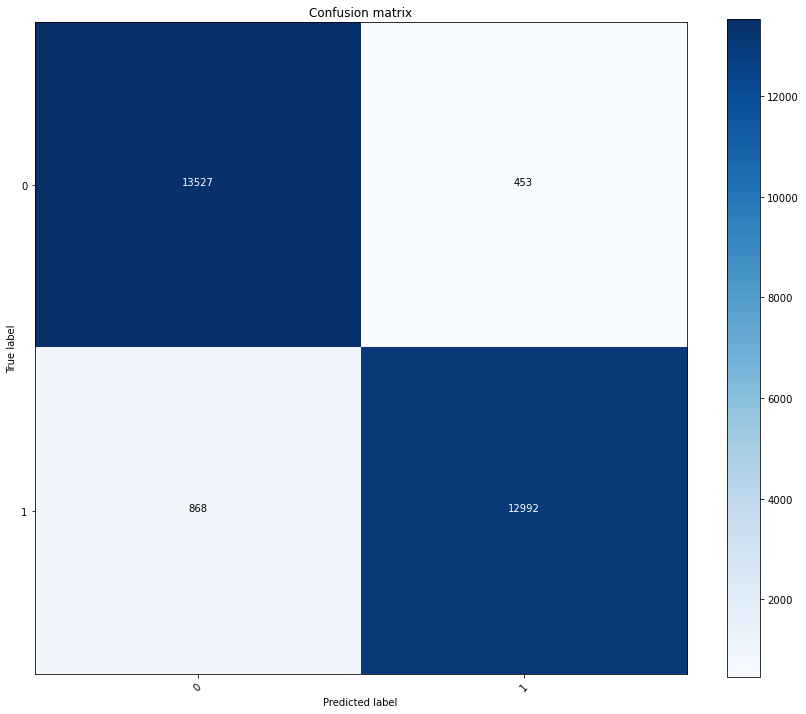

In [147]:
y_pred = model.predict(X_test)
y_expected = pd.DataFrame(y_test)
cnf_matrix = confusion_matrix(y_expected, y_pred.round())
plot_confusion_matrix(cnf_matrix, classes=[0,1])
plt.show()

- The metrics look pretty strong on the test set....

In [148]:
acc = accuracy_score(y_test, y_pred.round())
prec = precision_score(y_test, y_pred.round())
rec = recall_score(y_test, y_pred.round())
f1 = f1_score(y_test, y_pred.round())

In [149]:
### Store results in dataframe for comparing various Models
model_results = pd.DataFrame([['UnderSampledNeuralNetwork', acc, 1-rec, rec, prec, f1]],
               columns = ['Model', 'Accuracy', 'FalseNegRate', 'Recall', 'Precision', 'F1 Score'])
results_testset = results_testset.append(model_results, ignore_index = True)
results_testset

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,RandomForest,0.985865,0.101577,0.898423,0.983681,0.939121
1,DecisionTree,0.979895,0.078573,0.921427,0.913634,0.917514
2,PlainNeuralNetwork,0.984506,0.117429,0.882571,0.988517,0.932544
3,WeightedNeuralNetwork,0.961682,0.058155,0.941845,0.785232,0.856438
4,UnderSampledNeuralNetwork,0.955172,0.050503,0.949497,0.959775,0.954608
5,OverSampledNeuralNetwork,0.946794,0.046696,0.953304,0.708750,0.813035
6,OverSampledNeuralNetwork,0.906061,0.017834,0.982166,0.564972,0.717319
7,OverSampledNeuralNetwork,0.984380,0.120531,0.879469,0.990779,0.931812
8,UnderSampledNeuralNetwork,0.952550,0.062626,0.937374,0.966307,0.951621


....But the model fails on non fraudulent transactions as shown below.

## Oversampling technique using SMOTE
(Synthetic Minority Oversample TEchnique)
- the alternative to down-sampling is the upsampling of the minority class to the same level as the dominant one.
- This can be achieved with the SMOTE method where a new vector is generated between 2 existing datapoints. Applying this technique allows to massively increase the number of fraudulent transactions

In [123]:
train_df = pd.read_csv("../Data/SMOTE/SMOTE.csv")
test_df = pd.read_csv("../Data/test.csv")

In [124]:
X_train = train_df.iloc[:, :-1]
y_train = pd.DataFrame(train_df.iloc[:, -1])
X_test = test_df.iloc[:, :-1]
y_test = pd.DataFrame(test_df.iloc[:, -1])

In [125]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_train_SMOTE = y_train
y_test = np.array(y_test)

In [70]:
model = Sequential([
    Dense(units=49, input_dim = 98,activation='relu'),   # input of 98 columns as shown above
    Dense(units=80,activation='relu'),
    Dropout(0.5),
    Dense(80,activation='relu'),
    Dense(49,activation='relu'),
    Dense(1,activation='sigmoid'),                        # binary classification fraudulent or not
])

In [71]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=200,epochs=20)

Epoch 1/20
504294/504294 [==============================] - 12s 25us/step - loss: 0.1178 - accuracy: 0.9407
Epoch 2/20
504294/504294 [==============================] - 12s 23us/step - loss: 0.0920 - accuracy: 0.9519
Epoch 3/20
504294/504294 [==============================] - 11s 23us/step - loss: 0.0871 - accuracy: 0.9547
Epoch 4/20
504294/504294 [==============================] - 12s 23us/step - loss: 0.0838 - accuracy: 0.9565
Epoch 5/20
504294/504294 [==============================] - 11s 23us/step - loss: 0.0816 - accuracy: 0.9578
Epoch 6/20
504294/504294 [==============================] - 12s 23us/step - loss: 0.0799 - accuracy: 0.9591
Epoch 7/20
504294/504294 [==============================] - 12s 23us/step - loss: 0.0787 - accuracy: 0.9598
Epoch 8/20
504294/504294 [==============================] - 11s 23us/step - loss: 0.0777 - accuracy: 0.9604
Epoch 9/20
504294/504294 [==============================] - 11s 23us/step - loss: 0.0767 - accuracy: 0.9610
Epoch 10/20
504294/504294 [=

In [72]:
train_predictions_oversampled_SMOTE = model.predict(X_train)
test_predictions_oversampled_SMOTE = model.predict(X_test)

Confusion matrix, without normalization
[[79493  4547]
 [  542 11065]]


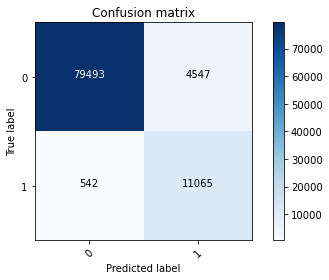

In [73]:
y_pred = model.predict(X_test)
y_expected = pd.DataFrame(y_test)
cnf_matrix = confusion_matrix(y_expected, y_pred.round())
plot_confusion_matrix(cnf_matrix, classes=[0,1])
plt.show()

- Notice the absence of False Negatives. The model is able to detect all fraudulent transactions on the unseen test set.

In [74]:
acc = accuracy_score(y_test, y_pred.round())
prec = precision_score(y_test, y_pred.round())
rec = recall_score(y_test, y_pred.round())
f1 = f1_score(y_test, y_pred.round())

In [75]:
### Store results in dataframe for comparing various Models
model_results = pd.DataFrame([['OverSampledNeuralNetwork', acc, 1-rec, rec, prec, f1]],
               columns = ['Model', 'Accuracy', 'FalseNegRate', 'Recall', 'Precision', 'F1 Score'])
results_testset = results_testset.append(model_results, ignore_index = True)
results_testset

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,RandomForest,0.985865,0.101577,0.898423,0.983681,0.939121
1,DecisionTree,0.979895,0.078573,0.921427,0.913634,0.917514
2,PlainNeuralNetwork,0.984506,0.117429,0.882571,0.988517,0.932544
3,WeightedNeuralNetwork,0.961682,0.058155,0.941845,0.785232,0.856438
4,UnderSampledNeuralNetwork,0.955172,0.050503,0.949497,0.959775,0.954608
5,OverSampledNeuralNetwork,0.946794,0.046696,0.953304,0.708750,0.813035


## Oversampling technique using ADASYN
(Synthetic Minority Oversample TEchnique)
- the alternative to down-sampling is the upsampling of the minority class to the same level as the dominant one.
- This can be achieved with the SMOTE method where a new vector is generated between 2 existing datapoints. Applying this technique allows to massively increase the number of fraudulent transactions

In [126]:
train_df = pd.read_csv("../Data/ADASYN/ADASYN.csv")
test_df = pd.read_csv("../Data/test.csv")

In [127]:
X_train = train_df.iloc[:, :-1]
y_train = pd.DataFrame(train_df.iloc[:, -1])
X_test = test_df.iloc[:, :-1]
y_test = pd.DataFrame(test_df.iloc[:, -1])

In [128]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_train_ADASYN = y_train
y_test = np.array(y_test)

In [79]:
model = Sequential([
    Dense(units=49, input_dim = 98,activation='relu'),   # input of 98 columns as shown above
    Dense(units=80,activation='relu'),
    Dropout(0.5),
    Dense(80,activation='relu'),
    Dense(49,activation='relu'),
    Dense(1,activation='sigmoid'),                        # binary classification fraudulent or not
])

In [80]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=200,epochs=20)

Epoch 1/20
505860/505860 [==============================] - 13s 25us/step - loss: 0.2286 - accuracy: 0.9069
Epoch 2/20
505860/505860 [==============================] - 12s 24us/step - loss: 0.1831 - accuracy: 0.9299
Epoch 3/20
505860/505860 [==============================] - 12s 24us/step - loss: 0.1726 - accuracy: 0.9345
Epoch 4/20
505860/505860 [==============================] - 12s 24us/step - loss: 0.1653 - accuracy: 0.9373
Epoch 5/20
505860/505860 [==============================] - 12s 24us/step - loss: 0.1603 - accuracy: 0.9394
Epoch 6/20
505860/505860 [==============================] - 12s 24us/step - loss: 0.1565 - accuracy: 0.9413
Epoch 7/20
505860/505860 [==============================] - 13s 25us/step - loss: 0.1537 - accuracy: 0.9425
Epoch 8/20
505860/505860 [==============================] - 13s 25us/step - loss: 0.1511 - accuracy: 0.9439
Epoch 9/20
505860/505860 [==============================] - 12s 24us/step - loss: 0.1489 - accuracy: 0.9450
Epoch 10/20
505860/505860 [=

In [81]:
train_predictions_oversampled_ADASYN = model.predict(X_train)
test_predictions_oversampled_ADASYN = model.predict(X_test)

Confusion matrix, without normalization
[[75262  8778]
 [  207 11400]]


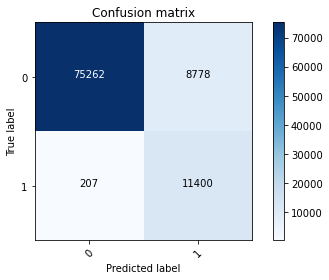

In [82]:
y_pred = model.predict(X_test)
y_expected = pd.DataFrame(y_test)
cnf_matrix = confusion_matrix(y_expected, y_pred.round())
plot_confusion_matrix(cnf_matrix, classes=[0,1])
plt.show()

- Notice the absence of False Negatives. The model is able to detect all fraudulent transactions on the unseen test set.

In [83]:
acc = accuracy_score(y_test, y_pred.round())
prec = precision_score(y_test, y_pred.round())
rec = recall_score(y_test, y_pred.round())
f1 = f1_score(y_test, y_pred.round())

In [84]:
### Store results in dataframe for comparing various Models
model_results = pd.DataFrame([['OverSampledNeuralNetwork', acc, 1-rec, rec, prec, f1]],
               columns = ['Model', 'Accuracy', 'FalseNegRate', 'Recall', 'Precision', 'F1 Score'])
results_testset = results_testset.append(model_results, ignore_index = True)
results_testset

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,RandomForest,0.985865,0.101577,0.898423,0.983681,0.939121
1,DecisionTree,0.979895,0.078573,0.921427,0.913634,0.917514
2,PlainNeuralNetwork,0.984506,0.117429,0.882571,0.988517,0.932544
3,WeightedNeuralNetwork,0.961682,0.058155,0.941845,0.785232,0.856438
4,UnderSampledNeuralNetwork,0.955172,0.050503,0.949497,0.959775,0.954608
5,OverSampledNeuralNetwork,0.946794,0.046696,0.953304,0.708750,0.813035
6,OverSampledNeuralNetwork,0.906061,0.017834,0.982166,0.564972,0.717319


All metrics are excellent for this last model.

## Oversampling technique using TGANs
(Synthetic Minority Oversample TEchnique)
- the alternative to down-sampling is the upsampling of the minority class to the same level as the dominant one.
- This can be achieved with the SMOTE method where a new vector is generated between 2 existing datapoints. Applying this technique allows to massively increase the number of fraudulent transactions

In [85]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [86]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

In [87]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [129]:
train_df = pd.read_csv("../Data/TGAN/TGAN.csv")
test_df = pd.read_csv("../Data/test.csv")

In [130]:
X_train = train_df.iloc[:, :-1]
y_train = pd.DataFrame(train_df.iloc[:, -1])
X_test = test_df.iloc[:, :-1]
y_test = pd.DataFrame(test_df.iloc[:, -1])

In [131]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_train_TGAN = y_train
y_test = np.array(y_test)

In [91]:
model = Sequential([
    Dense(units=49, input_dim = 98,activation='relu'),   # input of 98 columns as shown above
    Dense(units=80,activation='relu'),
    Dropout(0.5),
    Dense(80,activation='relu'),
    Dense(49,activation='relu'),
    Dense(1,activation='sigmoid'),                        # binary classification fraudulent or not
])

In [92]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=200,epochs=20)

Epoch 1/20
504240/504240 [==============================] - 13s 25us/step - loss: 0.0517 - accuracy: 0.9835
Epoch 2/20
504240/504240 [==============================] - 12s 24us/step - loss: 0.0359 - accuracy: 0.9883
Epoch 3/20
504240/504240 [==============================] - 13s 25us/step - loss: 0.0333 - accuracy: 0.9890
Epoch 4/20
504240/504240 [==============================] - 13s 26us/step - loss: 0.0319 - accuracy: 0.9896
Epoch 5/20
504240/504240 [==============================] - 13s 25us/step - loss: 0.0309 - accuracy: 0.9898
Epoch 6/20
504240/504240 [==============================] - 13s 25us/step - loss: 0.0300 - accuracy: 0.9902
Epoch 7/20
504240/504240 [==============================] - 12s 25us/step - loss: 0.0294 - accuracy: 0.9903
Epoch 8/20
504240/504240 [==============================] - 12s 25us/step - loss: 0.0287 - accuracy: 0.9905
Epoch 9/20
504240/504240 [==============================] - 12s 25us/step - loss: 0.0284 - accuracy: 0.9906
Epoch 10/20
504240/504240 [=

In [93]:
train_predictions_oversampled_TGAN = model.predict(X_train)
test_predictions_oversampled_TGAN = model.predict(X_test)

Confusion matrix, without normalization
[[83945    95]
 [ 1399 10208]]


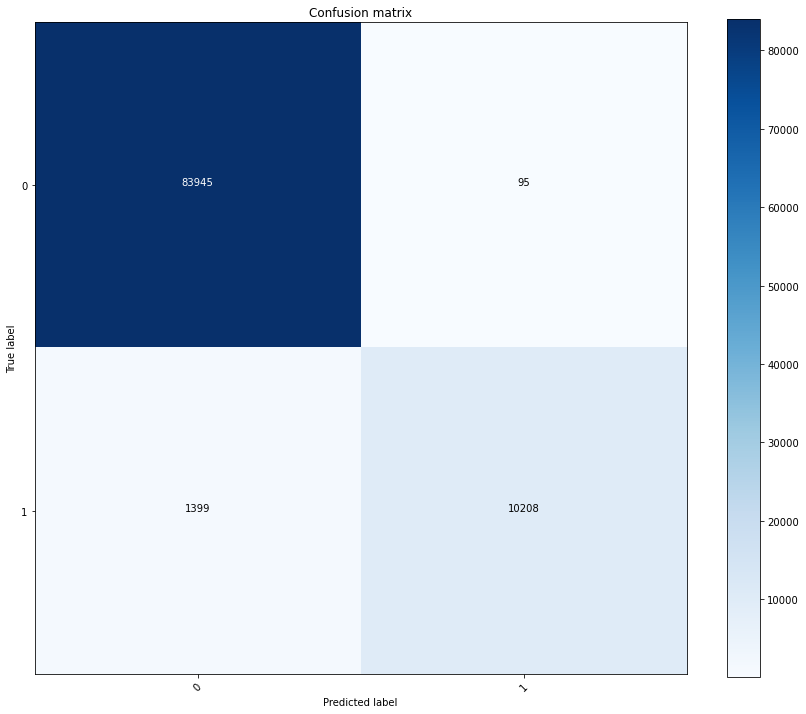

In [94]:
y_pred = model.predict(X_test)
y_expected = pd.DataFrame(y_test)
cnf_matrix = confusion_matrix(y_expected, y_pred.round())
plot_confusion_matrix(cnf_matrix, classes=[0,1])
plt.show()

- Notice the absence of False Negatives. The model is able to detect all fraudulent transactions on the unseen test set.

In [95]:
acc = accuracy_score(y_test, y_pred.round())
prec = precision_score(y_test, y_pred.round())
rec = recall_score(y_test, y_pred.round())
f1 = f1_score(y_test, y_pred.round())

In [96]:
### Store results in dataframe for comparing various Models
model_results = pd.DataFrame([['OverSampledNeuralNetwork', acc, 1-rec, rec, prec, f1]],
               columns = ['Model', 'Accuracy', 'FalseNegRate', 'Recall', 'Precision', 'F1 Score'])
results_testset = results_testset.append(model_results, ignore_index = True)
results_testset

,Model,Accuracy,FalseNegRate,Recall,Precision,F1 Score
0,RandomForest,0.985865,0.101577,0.898423,0.983681,0.939121
1,DecisionTree,0.979895,0.078573,0.921427,0.913634,0.917514
2,PlainNeuralNetwork,0.984506,0.117429,0.882571,0.988517,0.932544
3,WeightedNeuralNetwork,0.961682,0.058155,0.941845,0.785232,0.856438
4,UnderSampledNeuralNetwork,0.955172,0.050503,0.949497,0.959775,0.954608
5,OverSampledNeuralNetwork,0.946794,0.046696,0.953304,0.708750,0.813035
6,OverSampledNeuralNetwork,0.906061,0.017834,0.982166,0.564972,0.717319
7,OverSampledNeuralNetwork,0.984380,0.120531,0.879469,0.990779,0.931812


### Plot ROC curves of all the models 

In [178]:
from sklearn.metrics import roc_auc_score, confusion_matrix

Baseline AUC-ROC: 0.9405774350130177
Weighted AUC-ROC: 0.9557261432614623
Undersampled AUC-ROC: 0.9524851519486712
Oversampled SMOTE AUC-ROC: 0.9495994263297022
Oversampled ADASYN AUC-ROC: 0.9388578362849281
Oversampled TGAN AUC-ROC: 0.9391694358436479
Baseline Confusion Matrix : 
 [[83921   119]
 [ 1363 10244]]


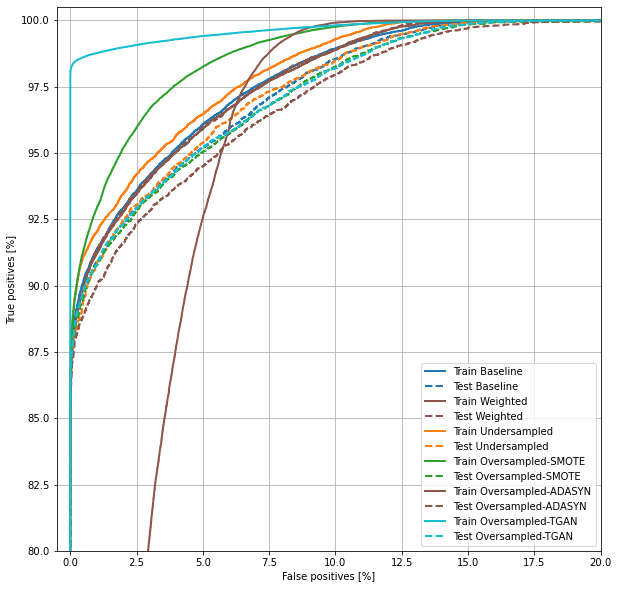

In [189]:
plot_roc("Train Baseline", y_train_baseline, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", y_train_baseline, train_predictions_weighted, color=colors[5])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[5], linestyle='--')

plot_roc("Train Undersampled", y_train_undersampled, train_predictions_undersampled, color=colors[1])
plot_roc("Test Undersampled", y_test_undersampled, test_predictions_undersampled, color=colors[1], linestyle='--')

plot_roc("Train Oversampled-SMOTE", y_train_SMOTE, train_predictions_oversampled_SMOTE, color=colors[2])
plot_roc("Test Oversampled-SMOTE", y_test, test_predictions_oversampled_SMOTE, color=colors[2], linestyle='--')

plot_roc("Train Oversampled-ADASYN", y_train_ADASYN, train_predictions_oversampled_ADASYN, color=colors[5])
plot_roc("Test Oversampled-ADASYN", y_test, test_predictions_oversampled_ADASYN, color=colors[5], linestyle='--')

plot_roc("Train Oversampled-TGAN", y_train_TGAN, train_predictions_oversampled_TGAN, color=colors[9])
plot_roc("Test Oversampled-TGAN", y_test, test_predictions_oversampled_TGAN, color=colors[9], linestyle='--')

plt.legend(loc='lower right')

print('Baseline AUC-ROC:',roc_auc_score(y_test, test_predictions_baseline.round()))
print('Weighted AUC-ROC:',roc_auc_score(y_test, test_predictions_weighted.round()))
print('Undersampled AUC-ROC:',roc_auc_score(y_test_undersampled, test_predictions_undersampled.round()))
print('Oversampled SMOTE AUC-ROC:',roc_auc_score(y_test, test_predictions_oversampled_SMOTE.round()))
print('Oversampled ADASYN AUC-ROC:',roc_auc_score(y_test, test_predictions_oversampled_ADASYN.round()))
print('Oversampled TGAN AUC-ROC:',roc_auc_score(y_test, test_predictions_oversampled_TGAN.round()))

print('Baseline Confusion Matrix : \n', confusion_matrix(y_test, test_predictions_baseline.round()))


In [104]:
train_predictions_oversampled_ADASYN.shape

(505860, 1)

In [181]:
test_predictions_baseline

array([[0.        ],
       [0.10863179],
       [0.        ],
       ...,
       [0.        ],
       [0.        ],
       [0.08387432]], dtype=float32)